In [96]:
import torch
from torch import optim, nn

from torchvision import datasets, models
import torchvision.transforms.v2 as T
from torch.utils.data import Dataset, DataLoader, Subset

from torchinfo import summary

import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True

from tqdm import tqdm

In [99]:
train_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=nn.Sequential(T.ToTensor(), 
                            T.Resize(224), 
                            T.Normalize(mean=(0.5071, 0.4867, 0.4408), std=(0.2675, 0.2565, 0.2761)),
                            T.RandomHorizontalFlip(), 
                            T.RandomRotation(10),
                            )
)

Files already downloaded and verified


In [100]:
test_val_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=nn.Sequential(T.ToTensor(), 
                            T.Resize(224))
    )

val_data, test_data = torch.utils.data.random_split(test_val_data, [5000, 5000])

Files already downloaded and verified


In [101]:
len(train_data), len(val_data), len(test_data)

(50000, 5000, 5000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7904432..2.025353].


Text(0.5, 1.0, 'Target = 19')

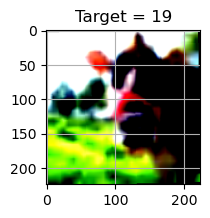

In [103]:
plt.figure(figsize=(2,2))
plt.imshow(train_data[0][0].permute(1, 2, 0))
plt.title("Target = " +str(train_data[0][1]))

In [104]:
image_shape = train_data[0][0].shape
image_shape = (1,) + tuple(image_shape)
image_shape

(1, 3, 224, 224)

I divide the labels in NUM_TASKS sets, each containing SET_SIZE labels. The sets are disjoint.

In [105]:
num_tasks = 10
set_size = 100 // num_tasks

Target separators define by simple inequality which set does a label belong to.

In [108]:
target_sep = [(i*set_size, (i+1)*set_size) for i in range(num_tasks)]
target_sep

[(0, 10),
 (10, 20),
 (20, 30),
 (30, 40),
 (40, 50),
 (50, 60),
 (60, 70),
 (70, 80),
 (80, 90),
 (90, 100)]

Training process:
stepwise learning on each of the sets. The labels in each training session are new for the model. 
The accuracy is measured on the test data with labels from set 0 after each training session.

In [109]:
def make_dataloaders(dataset, batch_size=32):
    loaders = [None for _ in range(num_tasks)]
    for i, separator in tqdm(enumerate(target_sep)):
        indx = [j for j, (_, target) in enumerate(dataset) if separator[0] <= target < separator[1]]
        subset = Subset(dataset, indx)
        loaders[i] = DataLoader(subset, batch_size=batch_size,
                                   shuffle=True, num_workers=1)
    return loaders

In [110]:
train_loaders = make_dataloaders(train_data)
val_loaders = make_dataloaders(val_data)
test_loaders = make_dataloaders(test_data)

10it [08:43, 52.40s/it]
10it [00:11,  1.17s/it]
10it [00:11,  1.17s/it]


In [64]:
for i in train_loaders[0]:
    print(i[0].shape, i[1].shape)
    print(i[1])
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])
tensor([3, 8, 8, 1, 0, 0, 9, 6, 6, 8, 7, 8, 6, 7, 3, 7, 6, 7, 6, 0, 5, 4, 4, 1,
        3, 4, 5, 1, 5, 4, 0, 3])


Select a model

In [66]:
def evaluate(model, test_loader):
    model.eval()
    scores = 0.
    for data, target in test_loader:
        pred = model(data.to(device)).argmax(dim=1)
        scores += (pred == target.to(device)).float().mean(dim=0)
    return scores / len(test_loader) 

FIX: make test_loader a keyword argument in train function

In [67]:
def train(model, optimizer, criterion, train_loader, val_loader, num_epochs=30):
    losses = torch.zeros(num_epochs)
    acc_scores = torch.empty((2, num_epochs)) 
    
    for i in tqdm(range(num_epochs)):
        model.train()
        
        for data, target in train_loader:    
            optimizer.zero_grad()
            output = model(data.to(device))            
            loss = criterion(output, target.to(device))
            losses[i] += loss.data.to("cpu") / len(train_loader)

            loss.backward()
            optimizer.step()

        model.eval()
        acc_scores[0][i] = evaluate(model, train_loader)
        acc_scores[1][i] = evaluate(model, val_loader)

    return losses, acc_scores[0], acc_scores[1]

In [119]:
def visualize(losses, acc_scores, filename="1"):
        
    fig, axs = plt.subplots(2, 1, figsize=(5,5), layout="tight")
    axs[0].plot(losses)
    axs[0].title.set_text("Loss")
    axs[1].plot(acc_scores[0], label="train")
    axs[1].plot(acc_scores[1], label="val")
    axs[1].title.set_text("Accuracy")
    axs[1].set_xlabel("Epoch")
    axs[1].legend()

    plt.savefig("plots/"+filename)

Training in class incremental setting:

In [69]:
def train_class_incremental(model, optimizer, criterion, num_tasks, num_epochs_per_task):
    acc_on_task_0 = torch.empty(num_tasks)
    acc_on_last_task = torch.empty(num_tasks)
    
    for i in range(num_tasks):
        _, acc_train, acc_val = train(model, optimizer, criterion, train_loaders[i], val_loaders[i], num_epochs_per_task)

        acc_on_last_task[i] = acc_val[-1]
        acc_on_task_0[i] = evaluate(model, val_loaders[0])

        print("Task ", i)
        print("Accuracy on task ", i, ": ", acc_on_last_task[i])
        print("Accuracy on task ", 0, ": ",acc_on_task_0[i])
        
    return acc_on_last_task, acc_on_task_0

TODO: heatmap (acc on task - task elapsed)

In [70]:
def visualize_class_incremental(acc_last, acc_0, filename=""):
    plt.figure(figsize=(5,3))
    plt.plot(range(1, len(acc_last)+1), acc_last, label="last task")
    plt.plot(range(1, len(acc_0)+1), acc_0, label="task 0")
    plt.xlabel("Task number")
    plt.title("Test accuracy")
    plt.legend()
    plt.show()
    plt.savefig("plots/class_incremental_" + filename)

In [71]:
class MyModel(nn.Module):
    def __init__(self, backbone):
        super(MyModel, self).__init__()
        self.backbone = backbone
        self.name = type(backbone).__name__
        
        self.top_layers = nn.Sequential(nn.ReLU(), 
                                        nn.Linear(1000, 100),
                                        nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.top_layers(x)
        return x


class ExperimentTrainer():
    def __init__(self, model, optimizer, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.criterion = loss_fn

        self.acc_full = [[] * num_tasks]
        self.acc_last = []
        self.acc_0 = []

    def train_full(self, task_id=0, num_epochs=20):
        loss, acc_train, acc_val = train(self.model, self.optimizer, self.criterion, 
                          train_loaders[task_id], val_loaders[task_id], num_epochs)
        self.acc_full[task_id] = acc_val
        print("Model: ", self.model.name, ", weights: ", )
        print("Accuracy on task", task_id, ": ", acc_val[-1].item())
        visualize(loss, (acc_train, acc_val), filename="_".join(["task", str(task_id), self.model.name, str(num_epochs), "ep"]))
        

    def train_class_inc(self, num_tasks=10, num_epochs_per_task=10):
        acc_last, acc_0 = train_class_incremental(self.model, self.optimizer, 
                                                    self.criterion, num_tasks, 
                                                    num_epochs_per_task)
        self.acc_last = acc_last
        self.acc_0 = acc_0

        print("Model: ", self.model.name, ", weights: ", )
        visualize_class_incremental(self.acc_last, self.acc_0, 
                                    filename="_".join(["CIL", str(num_tasks), self.model.name, str(num_epochs_per_task), "ep"])
                                   )


In [72]:
summary(MyModel(models.resnet50()), image_shape)

Layer (type:depth-idx)                        Output Shape              Param #
MyModel                                       [1, 100]                  --
├─ResNet: 1-1                                 [1, 1000]                 --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          70,400
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]          379,392

In [65]:
from torch import device
device = device("cuda")

In [35]:
mymodel = MyModel(models.resnet50())
trainer = ExperimentTrainer(mymodel.to(device), 
                            optim.SGD(mymodel.parameters(), lr=1e-3,
                                      momentum=0.9, weight_decay=5e-5),
                            nn.NLLLoss())

100%|██████████| 60/60 [12:45<00:00, 12.75s/it]


Accuracy on task 0 :  tensor(0.7085)


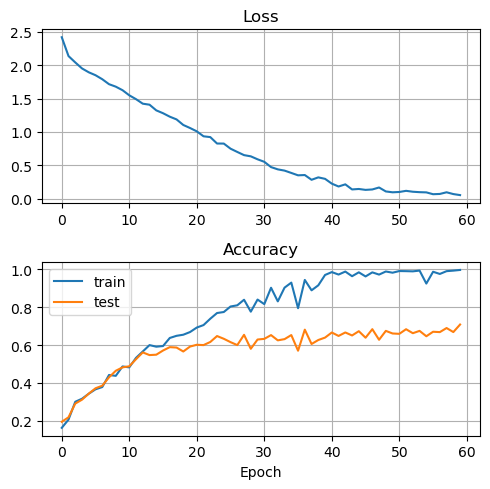

In [352]:
trainer.train_full(task_id=0, num_epochs=60)

100%|██████████| 20/20 [04:09<00:00, 12.46s/it]


Task  0
Accuracy on task  0 :  tensor(0.6217)
Accuracy on task  0 :  tensor(0.6168)


100%|██████████| 20/20 [04:05<00:00, 12.28s/it]


Task  1
Accuracy on task  1 :  tensor(0.6048)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 20/20 [04:07<00:00, 12.39s/it]


Task  2
Accuracy on task  2 :  tensor(0.6621)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 20/20 [04:07<00:00, 12.39s/it]


Task  3
Accuracy on task  3 :  tensor(0.5995)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 20/20 [04:06<00:00, 12.30s/it]


Task  4
Accuracy on task  4 :  tensor(0.6668)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 20/20 [04:05<00:00, 12.29s/it]


Task  5
Accuracy on task  5 :  tensor(0.6912)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 20/20 [04:08<00:00, 12.40s/it]


Task  6
Accuracy on task  6 :  tensor(0.6387)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 20/20 [04:08<00:00, 12.41s/it]


Task  7
Accuracy on task  7 :  tensor(0.6366)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 20/20 [04:07<00:00, 12.38s/it]


Task  8
Accuracy on task  8 :  tensor(0.6348)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 20/20 [04:03<00:00, 12.18s/it]


Task  9
Accuracy on task  9 :  tensor(0.6934)
Accuracy on task  0 :  tensor(0.)


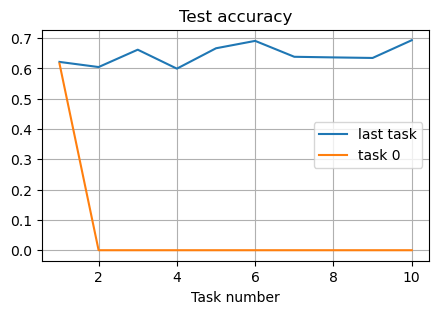

<Figure size 640x480 with 0 Axes>

In [41]:
trainer.train_class_inc(num_tasks, num_epochs_per_task=20)

In [80]:
from timm.models import TinyVit

In [82]:
vit = TinyVit()

In [83]:
summary(vit, image_shape)

Layer (type:depth-idx)                             Output Shape              Param #
TinyVit                                            [1, 1000]                 --
├─PatchEmbed: 1-1                                  [1, 96, 56, 56]           --
│    └─ConvNorm: 2-1                               [1, 48, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 48, 112, 112]         1,296
│    │    └─BatchNorm2d: 3-2                       [1, 48, 112, 112]         96
│    └─GELU: 2-2                                   [1, 48, 112, 112]         --
│    └─ConvNorm: 2-3                               [1, 96, 56, 56]           --
│    │    └─Conv2d: 3-3                            [1, 96, 56, 56]           41,472
│    │    └─BatchNorm2d: 3-4                       [1, 96, 56, 56]           192
├─Sequential: 1-2                                  [1, 768, 7, 7]            --
│    └─ConvLayer: 2-4                              [1, 96, 56, 56]           --
│    │    └─Sequential: 3-5

In [115]:
vit = MyModel(TinyVit())
vit_trainer = ExperimentTrainer(vit.to(device), optim.Adam(vit.parameters(), lr=1e-4),
                                nn.NLLLoss())

100%|██████████| 30/30 [11:22<00:00, 22.76s/it]


Model:  TinyVit , weights: 
Accuracy on task 0 :  0.31985294818878174


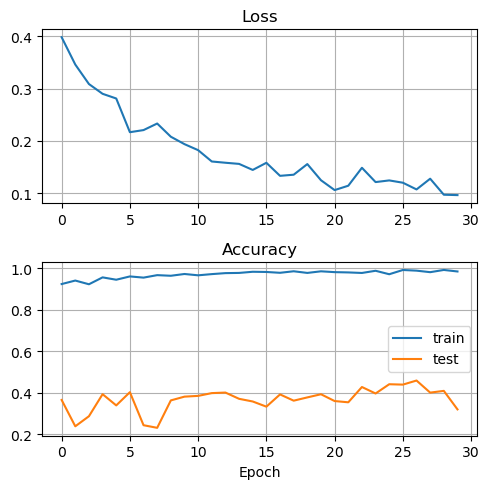

In [117]:
vit_trainer.train_full(task_id=0, num_epochs=30)

In [93]:
import numpy as np

np.log(10)

np.float64(2.302585092994046)

100%|██████████| 10/10 [03:48<00:00, 22.80s/it]


Task  0
Accuracy on task  0 :  tensor(0.4372)
Accuracy on task  0 :  tensor(0.4325)


100%|██████████| 10/10 [03:48<00:00, 22.88s/it]


Task  1
Accuracy on task  1 :  tensor(0.1510)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [03:48<00:00, 22.85s/it]


Task  2
Accuracy on task  2 :  tensor(0.3729)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [03:47<00:00, 22.72s/it]


Task  3
Accuracy on task  3 :  tensor(0.4218)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [03:45<00:00, 22.59s/it]


Task  4
Accuracy on task  4 :  tensor(0.3161)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [03:48<00:00, 22.83s/it]


Task  5
Accuracy on task  5 :  tensor(0.3570)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [03:46<00:00, 22.65s/it]


Task  6
Accuracy on task  6 :  tensor(0.3862)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [03:47<00:00, 22.80s/it]


Task  7
Accuracy on task  7 :  tensor(0.4688)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [03:48<00:00, 22.86s/it]


Task  8
Accuracy on task  8 :  tensor(0.3290)
Accuracy on task  0 :  tensor(0.)


100%|██████████| 10/10 [03:45<00:00, 22.51s/it]


Task  9
Accuracy on task  9 :  tensor(0.2376)
Accuracy on task  0 :  tensor(0.)
Model:  TinyVit , weights: 


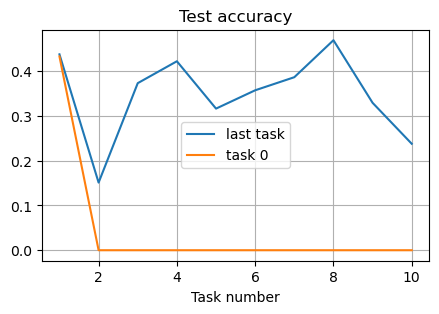

<Figure size 640x480 with 0 Axes>

In [118]:
vit_trainer.train_class_inc(num_epochs_per_task=10)

In [ ]:
for dl in val_loaders:
    print(evaluate(vit, dl))